In [1]:
import jax
import jax.numpy as jnp

In [6]:
from cohlib.utils import pickle_open
import cohlib.confs.utils as conf
import matplotlib.pyplot as plt
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(5e4)
mu = 2.3
K = 10
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K{K}/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

In [7]:
obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale50000/window1000/gseed0/K{K}/L25/lseed0/obs-pp_log/mu2.3/oseed0/obs_sim.pkl'
obs_load = pickle_open(obs_path)
obs = obs_load['obs'] 
from cohlib.utils import naive_estimator
empirical_est = naive_estimator(obs)[9,:,:]*1e6

In [93]:
# m_step_name = 'testing-factor-anucpen'
m_step_name = 'testing-factor-igprior-anucpen'
# test_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale50000/window1000/gseed0/K10/L25/lseed0/obs-pp_log/mu2.3/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-m_step_testing/empirical-init/newton-10_em-50/res.pkl'
test_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale50000/window1000/gseed0/K{K}/L25/lseed0/obs-pp_log/mu2.3/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-{m_step_name}/empirical-init/newton-10_em-19/res.pkl'

res_new = pickle_open(test_path)

In [94]:
lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
eigvals_true = jnp.zeros(K)
eigvals_true = eigvals_true.at[0].set(lrccn_true.eigvals.squeeze())

lowrank gCoh: 0.603
fullank gCoh: 0.588


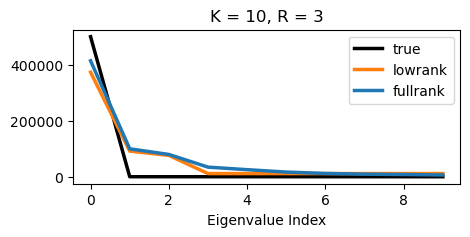

In [95]:
r = 19
lw = 2.5
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(eigvals_true, linewidth=lw, color='k', label='true')
eigvals_new = jnp.linalg.eigh(res_new['track']['ccn'][r].gamma.squeeze())[0][::-1]
ax.plot(eigvals_new, linewidth=lw, color='tab:orange', label='lowrank')
# plt.plot(jnp.linalg.eigh(res['track']['ccn'][r].gamma.squeeze())[0])
eigvals_old = jnp.linalg.eigh(res['track']['ccn'][19].gamma.squeeze())[0][::-1]
ax.plot(eigvals_old, linewidth=lw, color='tab:blue', label='fullrank')

gcoh_new = eigvals_new[0] / eigvals_new.sum()
print(f'lowrank gCoh: {gcoh_new:.3f}')
gcoh_old = eigvals_old[0] / eigvals_old.sum()
print(f'fullank gCoh: {gcoh_old:.3f}')

ax.set_title(f'K = {K}, R = 3')
ax.set_xlabel('Eigenvalue Index')
plt.legend()
# plt.plot(jnp.linalg.eigh(res['ccn_est'].gamma.squeeze())[0])

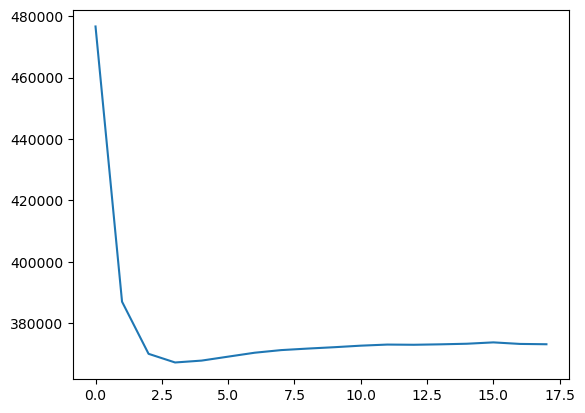

In [96]:
temp = [jnp.linalg.eigh(res_new['track']['ccn'][r].gamma.squeeze())[0][-1] for r in range(19)]
plt.plot(temp[1:])

In [192]:
jnp.diag(res['ccn_est'].gamma.squeeze())

Array([ 43693.715  -4.122529j,  41538.465 +22.102638j,
        94615.54 -117.7446j  ,  71093.28  +28.833466j,
        69140.64  -23.79888j ,  59404.18  -21.16904j ,
        56890.31  +53.53673j ,  75106.21  +22.516726j,
       123263.07  +91.423615j,  65751.27  +32.43869j ], dtype=complex64)

In [23]:
r = 19
alphas = res['track']['alphas'][r]
Upss = res['track']['Upss'][r]

In [24]:
def m_step_fullrank(alphas_outer, Upss, options=None):
    return (alphas_outer + Upss).mean(-1)

alphas_outer = jnp.einsum('nkl,nil->nkil', alphas, alphas.conj())
gamma_update = m_step_fullrank(alphas_outer, 2*Upss)
Sigma_sum_new = (alphas_outer + 2*Upss).sum(-1).squeeze()
L_new = alphas_outer.shape[-1]

In [25]:

result = optimize_m_step(Sigma_sum_new, rank=R, L=L_new, key=key)

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3198: RuntimeWarning: overflow encountered in cast
  out = np.asarray(object, dtype=dtype)


In [35]:
S = Sigma_sum_new
rank = 3
init_sigma2=1e-2

K = S.shape[0]
if key is None:
    key = jax.random.PRNGKey(0)

# Initialize B randomly
B_init = jax.random.normal(key, (K, rank)) + 1j * jax.random.normal(key, (K, rank))
B_init_r = complex_to_real_matrix(B_init)
log_sigma2_init = jnp.log(init_sigma2)

loss_fn = make_loss_fn(S, L)

# Combine parameters into tuple
params_init = (B_init_r, log_sigma2_init)

def flattened_loss(flat_params):
    B_r_flat, log_sigma2 = flat_params[:-1], flat_params[-1]
    B_r = B_r_flat.reshape((K, 2 * rank))
    return loss_fn((B_r, log_sigma2))

# Flatten for JAXopt
flat_init = jnp.concatenate([params_init[0].ravel(), jnp.array([params_init[1]])])

solver = ScipyMinimize(fun=flattened_loss, method="BFGS")
result = solver.run(flat_init)
flat_opt = result.params

# # Unpack result
# B_r_opt = flat_opt[:-1].reshape((K, 2 * rank))
# log_sigma2_opt = flat_opt[-1]
# sigma2_opt = jnp.exp(log_sigma2_opt)
# B_opt = real_to_complex_matrix(B_r_opt)

# # Final Gamma estimate
# Gamma_opt = B_opt @ B_opt.conj().T + sigma2_opt * jnp.eye(K)

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3198: RuntimeWarning: overflow encountered in cast
  out = np.asarray(object, dtype=dtype)


In [37]:
result.params

Array([ 17890.736  ,  13589.919  ,  -1610.8456 ,  19423.17   ,
        18986.045  ,   7183.301  , -10851.249  ,  -5725.2583 ,
        -5970.5317 ,   6098.4443 ,   6414.264  ,   1106.9296 ,
       -17363.53   , -14645.668  ,    637.3905 ,   7160.8286 ,
        -2095.3745 ,   2983.3035 ,   4657.053  ,    463.46112,
         2487.5562 ,  15736.165  ,   9632.27   ,   2679.998  ,
         9917.3125 ,   7613.3735 ,  -3409.715  ,  27010.496  ,
        17065.215  ,  10268.325  ,  10876.772  ,   9265.624  ,
         -812.99536,  12505.596  ,  10910.601  ,   4475.8975 ,
          612.19507,    610.13074,   1095.7281 ,   -426.96875,
        -2172.8752 ,    368.7631 ,  -4365.652  ,  -6551.8706 ,
         4790.2183 ,  -1417.0343 ,  -8937.571  ,    514.3048 ,
       -10223.459  ,  -7073.134  ,  -3633.2683 , -12273.441  ,
        -4273.6587 ,  -4055.0078 ,   9630.795  ,   8630.946  ,
        -4024.2615 ,   8116.5244 ,  14272.996  ,    194.07117,
       -10192.356  ], dtype=float32)

In [38]:
params = params_init
B_r, log_sigma2 = params
sigma2 = jnp.exp(log_sigma2)
B = real_to_complex_matrix(B_r)
K = S.shape[0]

# Gamma = BB^H + sigma^2 * I
BBH = B @ B.conj().T
Gamma = BBH + sigma2 * jnp.eye(K)

# Cholesky for log determinant
L_chol = jnp.linalg.cholesky(Gamma)
logdet = 2.0 * jnp.sum(jnp.log(jnp.real(jnp.diag(L_chol))))  # Make real

# Solve Gamma^{-1} @ S
Gamma_inv_S = cho_solve((L_chol, True), S)
trace_term = jnp.trace(Gamma_inv_S)

L * jnp.real(logdet) + jnp.real(trace_term)  # Ensure output is real scalar

Array(1.1318129e+09, dtype=float32)

In [9]:
result['sigma2']

Array(12409.127, dtype=float32)

In [10]:
jnp.linalg.eigh(result['Gamma'])[0]

Array([ 12409.123,  12409.139,  20206.13 , 109673.58 , 197957.02 ],      dtype=float32)

In [83]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import cho_solve
from jaxopt import ScipyMinimize

def complex_to_real_matrix(X_c):
    return jnp.concatenate([jnp.real(X_c), jnp.imag(X_c)], axis=-1)

def real_to_complex_matrix(X_r):
    R = X_r.shape[1] // 2
    return X_r[:, :R] + 1j * X_r[:, R:]

def make_loss_fn_fixed_sigma2(S, L, sigma2):
    def loss_fn(B_r):
        B = real_to_complex_matrix(B_r)
        K = S.shape[0]

        # Compute Gamma = BB^H + sigma^2 I
        BBH = B @ B.conj().T
        Gamma = BBH + sigma2 * jnp.eye(K)

        # Cholesky decomposition
        L_chol = jnp.linalg.cholesky(Gamma)
        logdet = 2.0 * jnp.sum(jnp.log(jnp.real(jnp.diag(L_chol))))  # Ensure real dtype

        # Trace term
        Gamma_inv_S = cho_solve((L_chol, True), S)
        trace_term = jnp.trace(Gamma_inv_S)

        # Final real-valued loss
        return L * jnp.real(logdet) + jnp.real(trace_term)
    return loss_fn

def optimize_m_step_fixed_sigma2(S, rank, L, sigma2, key=None):
    K = S.shape[0]
    if key is None:
        key = jax.random.PRNGKey(0)

    # Initialize B randomly
    B_init = jax.random.normal(key, (K, rank)) + 1j * jax.random.normal(key, (K, rank))
    B_init_r = complex_to_real_matrix(B_init)

    loss_fn = make_loss_fn_fixed_sigma2(S, L, sigma2)

    solver = ScipyMinimize(fun=loss_fn, method="BFGS")
    result = solver.run(B_init_r)
    B_r_opt = result.params
    B_opt = real_to_complex_matrix(B_r_opt)

    # Final Gamma
    Gamma_opt = B_opt @ B_opt.conj().T + sigma2 * jnp.eye(K)

    return {
        "B": B_opt,
        "Gamma": Gamma_opt,
        "loss": result.state.fun_val
    }


In [115]:
R = 1
# result_fixed = optimize_m_step_fixed_sigma2(Sigma_sum_new, rank=R, L=L_new, sigma2=100, key=key)
result = optimize_m_step(Sigma_sum_new, rank=R, L=L_new, key=key)

/projectnb/stephenlab/jtauber/.conda/envs/sgc_env/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3198: RuntimeWarning: overflow encountered in cast
  out = np.asarray(object, dtype=dtype)


In [113]:
result['sigma2']

Array(inf, dtype=float32)

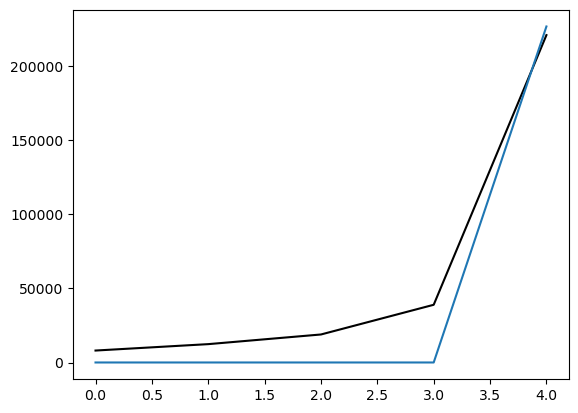

In [114]:
import matplotlib.pyplot as plt
eigs_empirical = jnp.linalg.eigh(gamma_update.squeeze())[0]
eigs_lr_fixed = jnp.linalg.eigh(result_fixed['Gamma'])[0]
eigs_lr = jnp.linalg.eigh(result['Gamma'])[0]
plt.plot(eigs_empirical, color='k')
plt.plot(eigs_lr_fixed)
plt.plot(eigs_lr)

In [56]:
import matplotlib.pyplot as plt

def plot_eigenvalue_spectrum(Gamma_est, Sigma_empirical=None, shrinkage_est=None, title=None):
    eig_Gamma = jnp.linalg.eigvalsh(Gamma_est)
    eig_Gamma = jnp.sort(jnp.real(eig_Gamma))[::-1]  # descending order

    plt.figure(figsize=(8, 5))
    plt.plot(eig_Gamma, 'o-', label='Low-rank estimate (Gamma)', linewidth=2)

    if Sigma_empirical is not None:
        eig_emp = jnp.linalg.eigvalsh(Sigma_empirical)
        eig_emp = jnp.sort(jnp.real(eig_emp))[::-1]
        plt.plot(eig_emp, 'o--', label='Empirical', alpha=0.7)

    if shrinkage_est is not None:
        eig_shrink = jnp.linalg.eigvalsh(shrinkage_est)
        eig_shrink = jnp.sort(jnp.real(eig_shrink))[::-1]
        plt.plot(eig_shrink, 'o-.', label='Shrinkage', alpha=0.7)

    plt.xlabel("Eigenvalue index")
    plt.ylabel("Eigenvalue magnitude")
    plt.title(title or "Eigenvalue Spectrum")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


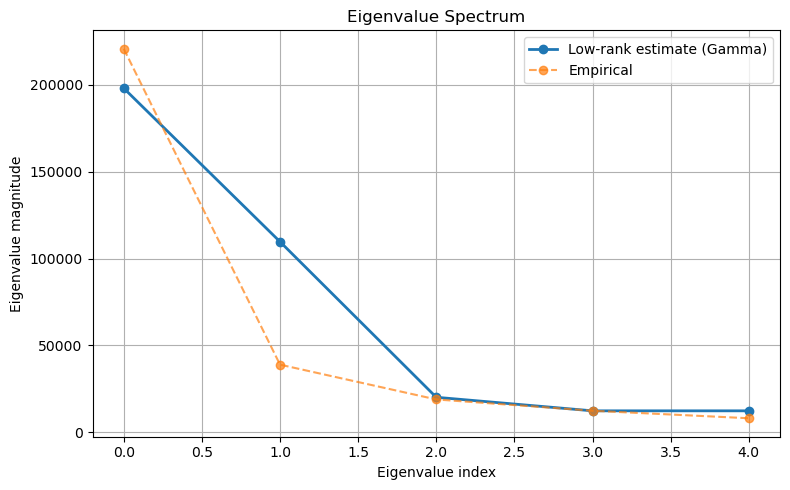

In [57]:
S = gamma_update.squeeze()
plot_eigenvalue_spectrum(result['Gamma'], S)

In [131]:
gamma_update

Array([[[ 63673.203  -7.3499754e-02j, -35258.14   -2.0989697e+03j,
          10147.825  +3.6434160e+04j, -15574.726  -4.8291207e+04j,
          27808.072  -3.8301345e+03j],
        [-35258.18   +2.1022385e+03j,  52492.945  +2.3051112e+00j,
         -15103.083  -4.3230914e+04j,  13158.163  +4.1069512e+04j,
         -32802.523  +5.1091284e+03j],
        [ 10141.506  -3.6441336e+04j, -15098.208  +4.3237812e+04j,
          65087.473  -1.0958235e+01j, -46566.81   -7.9787534e+03j,
            673.07825-4.2727383e+04j],
        [-15555.808  +4.8298289e+04j,  13144.107  -4.1074242e+04j,
         -46556.133  +8.0004600e+03j,  72638.266  -2.5970615e+01j,
           1772.5048 +3.2293645e+04j],
        [ 27812.797  +3.8305586e+03j, -32807.99   -5.1130234e+03j,
            676.7255 +4.2728359e+04j,   1764.0654 -3.2299066e+04j,
          45273.094  +5.1892819e+00j]]], dtype=complex64)

In [132]:
def initialize_B_from_empirical(S, rank):
    """Initialize B from the top eigenvectors of S"""
    eigvals, eigvecs = jnp.linalg.eigh(S)
    idx = jnp.argsort(eigvals)[::-1]  # descending
    top_vecs = eigvecs[:, idx[:rank]]
    top_vals = eigvals[idx[:rank]]
    B_init = top_vecs * jnp.sqrt(top_vals)[None, :]  # scale columns by sqrt eigenvalues
    return B_init

def make_loss_fn_strict_lowrank(S, L):
    def loss_fn(B_r):
        B = real_to_complex_matrix(B_r)
        K, R = B.shape

        # Compute Gamma = BB^H and its pseudo-inverse using Woodbury
        BBH = B @ B.conj().T
        BtB = B.conj().T @ B
        BtB_inv = jnp.linalg.inv(BtB)
        Gamma_inv = B @ BtB_inv @ B.conj().T

        # Compute log determinant of BB^H
        eigvals = jnp.linalg.eigvalsh(BBH)
        # Retain only non-zero eigvals (numerically)
        eigvals = jnp.where(eigvals > 1e-10, eigvals, 1e-10)
        logdet = jnp.sum(jnp.log(jnp.real(eigvals)))

        trace_term = jnp.trace(Gamma_inv @ S)

        return L * jnp.real(logdet) + jnp.real(trace_term)
    return loss_fn

def optimize_m_step_strict_lowrank(S, rank, L, key=None):
    K = S.shape[0]
    if key is None:
        key = jax.random.PRNGKey(0)

    B_init = initialize_B_from_empirical(S, rank)
    B_init_r = complex_to_real_matrix(B_init)

    loss_fn = make_loss_fn_strict_lowrank(S, L)
    solver = ScipyMinimize(fun=loss_fn, method="BFGS")
    result = solver.run(B_init_r)

    B_r_opt = result.params
    B_opt = real_to_complex_matrix(B_r_opt)
    Gamma_opt = B_opt @ B_opt.conj().T

    return {
        "B": B_opt,
        "Gamma": Gamma_opt,
        "loss": result.state.fun_val
    }


In [137]:
test = optimize_m_step_strict_lowrank(Sigma_sum_new, rank=5, L=L_new)

In [138]:
jnp.linalg.eigh(test['Gamma'])

EighResult(eigenvalues=Array([ 203513.97,  311404.25,  474004.12,  974232.2 , 5515971.  ],      dtype=float32), eigenvectors=Array([[-0.09460374+0.j        ,  0.38604644+0.j        ,
        -0.56364685+0.j        ,  0.5745244 +0.j        ,
        -0.44072938-0.j        ],
       [ 0.07572734-0.4984723j , -0.38860047+0.14703377j,
        -0.4764679 +0.35153762j,  0.1326859 +0.15351515j,
         0.425678  -0.01367192j],
       [-0.39874116-0.52747303j,  0.25715628-0.1779695j ,
         0.17051502+0.02021946j, -0.18629636+0.40657264j,
        -0.15008141+0.4614749j ],
       [-0.0694561 +0.15083043j,  0.28262234-0.52507925j,
        -0.28169075+0.25671852j, -0.3886637 +0.25025213j,
         0.11606565-0.49440023j],
       [-0.5212189 -0.01938035j, -0.4739987 +0.01667308j,
        -0.3342932 -0.2126307j , -0.36594632-0.28485036j,
        -0.35281953-0.08062721j]], dtype=complex64))

In [139]:
jnp.linalg.eigh(gamma_update)[0]

Array([[  8140.5337,  12456.165 ,  18960.12  ,  38969.293 , 220638.78  ]],      dtype=float32)

In [ ]:
Ks = [5, 10, 20]
K = 10
mu = 2.3
L = 25
# num_seeds = 200
# seed_mod = 0
# seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)
# plot_dict = get_plot_dict(eigval_all_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)